#### VQE and VQNHE (TFIM case)
This notebook calculates the energy of 7-site open boundary condition Transverse Field Ising Model (TFIM) via Variational Quantum Eigensolver and Variational Quantum Neural Hybrid Eigensolver.

#### The Hamiltonian of TFIM

$
H = -J \sum_{\langle i, j \rangle} \sigma_i^z \sigma_j^z - h \sum_{i} \sigma_i^x 
$

where:
- $ \sigma_i^z $ and $ \sigma_j^z $ are the Pauli-z matrices at sites $ i $ and $ j $.
- $ \sigma_i^x $ is the Pauli-x matrix at site $i $.
- $ J $ is the interaction strength between neighboring spins.
- $ h $ is the strength of the transverse magnetic field.
- The summation $ \langle i, j \rangle $ runs over all pairs of neighboring spins.

In matrix form for a single spin, the Pauli matrices are:

$ 
\sigma^z = \begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}, \quad 
\sigma^x = \begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix} 
$

### Import Library

In [1]:
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

### Parameters

In [2]:
nq = 7
n_layers = 2
initial_weights = np.random.random(2*nq-1)
shots = 30000
device = 'default.qubit'

torch.manual_seed(42)

In [3]:
j = 1.0 # Coupling
h = - 1.0 # Magnetic Field 

Parameterized Quantum Circuit (PQC) of VQE

In [4]:
def vqe_PQC(device: str, nq: int, n_layers: int, shots: int):
    # Define a device
    dev = qml.device(device, wires=nq, shots=shots)
    
    # Define the quantum function
    @qml.qnode(dev, interface='torch')
    def circuit(weights, hamiltonian: str):
        # Apply Hadamard gate on every qubit
        
        for q in range(nq):
            qml.Hadamard(wires=q)
            
        for i in range(n_layers):
         # Apply CNOT gate on the 1st layer
            for q in range(nq // 2):
                qml.CNOT(wires=[2 * q, (2 * q + 1)])
        
        # Apply Z-rotation gate to the 2nd layer
            for q in range(nq // 2):
                qml.RZ(weights[q], wires=2 * q + 1)
        
        # Apply CNOT gate on the 3rd layer
            for q in range(nq // 2):
                qml.CNOT(wires=[2 * q, (2 * q + 1)])
        
            # Apply CNOT gate on the 4th layer
            for q in range(nq // 2):
                qml.CNOT(wires=[2 * q + 1, 2 * (q + 1)])
        
            # Apply Z-rotation gate on the 5th layer
            for q in range(nq // 2):
                qml.RZ(weights[nq//2+q], wires=2 * (q + 1))
        
            # Apply CNOT gate on the 6th layer
            for q in range(nq // 2):
                qml.CNOT(wires=[2 * q + 1, 2 * (q + 1)])
        
        # Apply X-rotation gate on every qubit
        for q in range(nq):
            qml.RX(weights[nq-1+q], wires=q)
            
        for i, char in enumerate(hamiltonian):
            if char == 'X':
                qml.Hadamard(wires=i)
            
            if char == 'Y':
                qml.RX(-np.pi/2, wires=i)
                
        return qml.probs()
    
    return circuit

Function that calculates the energy of the TFIM via VQE

In [5]:
def vqe_nrg(qc, weights, j=1 ,h=-1):
    
    interaction = torch.tensor(0.0)
    field = torch.tensor(0.0)
    
    zz_observable = 'Z' * nq
    x_observables = ['I' * i + 'X' + 'I' * (nq - i - 1) for i in range(nq)]
    
    probs = {zz_observable: qc(weights, zz_observable)}

    for obs in x_observables:
        probs[obs] = qc(weights, obs) 

    
    for i in range(2**nq):
        state = format(i, f'0{nq}b')

        # Interaction term calculation
        for k in range(nq-1):
            if state[k] == state[k+1]:
                interaction = interaction + 1 * probs[zz_observable][i]
            else:
                interaction = interaction - 1 * probs[zz_observable][i]
        
        # Field term calculation
        for k in range(nq):
            if state[k] == '0':
                field = field + 1 * probs[x_observables[k]][i]
            else:
                field = field - 1 * probs[x_observables[k]][i]

    E = (j * interaction + h * field)
    E.requires_grad_(True)
    return E

In [6]:
vqe = vqe_PQC(device, nq, n_layers, shots)

In [7]:
pqc_initial_weights = torch.zeros(n_layers*(2*nq -1))

Diagram of VQE-PQC (ansatz)

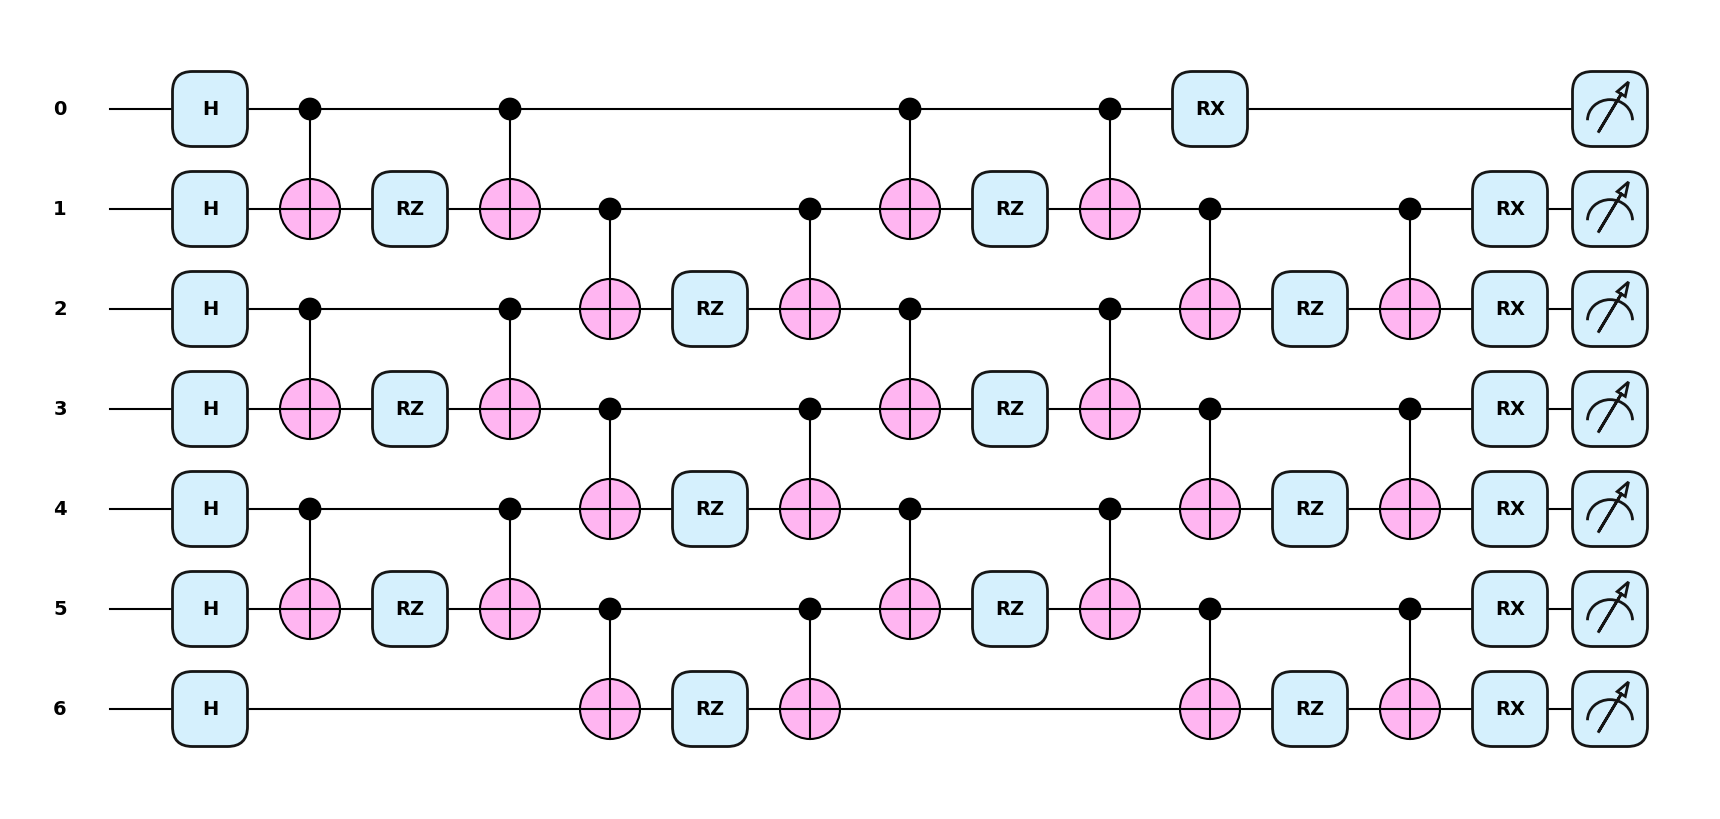

In [8]:
qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(vqe)(initial_weights, 'Z' * nq)
plt.show()

Train the PQC of VQE

In [9]:
weights = torch.tensor(pqc_initial_weights, dtype=torch.float32, requires_grad=True)

optimizer = optim.Adam([weights], lr=0.01)

vqe_energies = []
vqe_weights = []

for step in range(500):
    optimizer.zero_grad()
    energy = vqe_nrg(vqe, weights, j, h)
    energy.backward()
    optimizer.step()
    
    vqe_energies.append(energy.item())
    vqe_weights.append(weights.clone().detach().cpu().numpy())
    
    if step % 10 == 0:
        print(f"Step {step+1}, PQC Energy: {energy.item()}")

/var/folders/xk/ccyqzjcd4js8_v44j913ppm00000gn/T/ipykernel_93849/3748543207.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(pqc_initial_weights, dtype=torch.float32, requires_grad=True)


Step 1, PQC Energy: -6.974266666666664
Step 11, PQC Energy: -7.020666666666634
Step 21, PQC Energy: -7.139333333333308
Step 31, PQC Energy: -7.42719999999999
Step 41, PQC Energy: -7.765533333333327
Step 51, PQC Energy: -8.02419999999999
Step 61, PQC Energy: -8.170866666666658
Step 71, PQC Energy: -8.266266666666652
Step 81, PQC Energy: -8.279933333333322
Step 91, PQC Energy: -8.288466666666649
Step 101, PQC Energy: -8.274133333333328
Step 111, PQC Energy: -8.275266666666651
Step 121, PQC Energy: -8.274133333333317
Step 131, PQC Energy: -8.25859999999998
Step 141, PQC Energy: -8.267733333333316
Step 151, PQC Energy: -8.293399999999979
Step 161, PQC Energy: -8.266866666666669
Step 171, PQC Energy: -8.28899999999999
Step 181, PQC Energy: -8.272866666666651
Step 191, PQC Energy: -8.26979999999999
Step 201, PQC Energy: -8.26533333333332
Step 211, PQC Energy: -8.26586666666665
Step 221, PQC Energy: -8.27453333333332
Step 231, PQC Energy: -8.267533333333317
Step 241, PQC Energy: -8.2757999999

The energy of the TFIM via VQE

In [10]:
print(min(vqe_energies))
min_index = vqe_energies.index(min(vqe_energies))
trained_vqe_weights = vqe_weights[min_index]

-8.329999999999988


In [11]:
trained_vqe_energies = []
for i in range(100):
    trained_vqe_energies.append(vqe_nrg(vqe, trained_vqe_weights, j, h).detach().numpy())

#### Calculate the exact solution value of TFIM

In [12]:
H = np.zeros((2**nq, 2**nq))

In [13]:
# Function to calculate sigma_z
def sigma_z(i, N):
    return np.kron(np.kron(np.eye(2**i), np.array([[1, 0], [0, -1]])), np.eye(2**(N-i-1)))

# Function to calculate sigma_x
def sigma_x(i, N):
    return np.kron(np.kron(np.eye(2**i), np.array([[0, 1], [1, 0]])), np.eye(2**(N-i-1)))

In [14]:
# Constructing the Hamiltonian
for i in range(nq-1):
    H += -j * np.dot(sigma_z(i, nq), sigma_z(i+1, nq))
for i in range(nq):
    H += -h * sigma_x(i, nq)

In [15]:
# Calculating eigenvalues
eigenvalues, _ = np.linalg.eigh(H)

# Ground state energy
exact_solution = np.min(eigenvalues)
exact_solution

-8.56677223350563

Comparing the VQE result and the exact solution

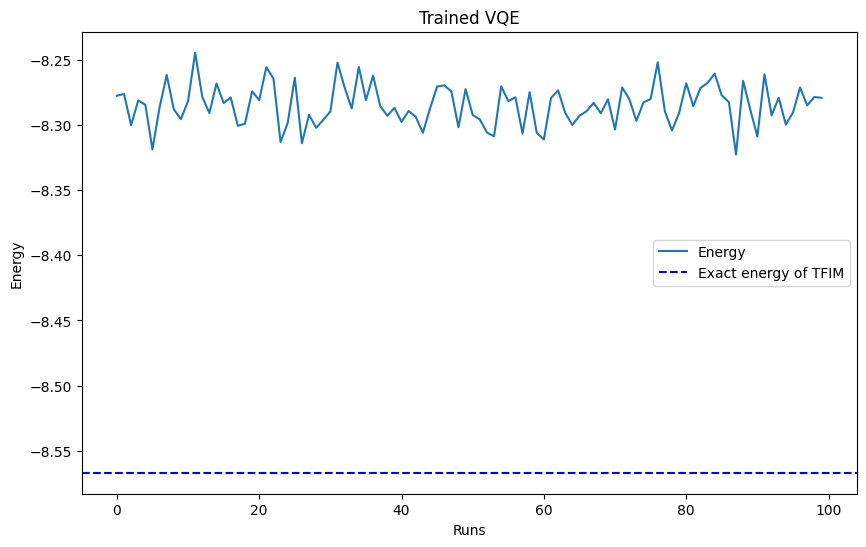

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(trained_vqe_energies, label='Energy')
# plt.axvline(x=phase_shift, color='r', linestyle='--', label='Neural network starts to learn')
plt.axhline(y=exact_solution, color='b', linestyle='--', label='Exact energy of TFIM')
plt.xlabel('Runs')
plt.ylabel('Energy')
plt.title('Trained VQE')
plt.legend()

PQC of VQNHE

In [17]:
def vqnhe_PQC(device: str, nq: int, shots: int):
    # Define a device
    dev = qml.device(device, wires=nq, shots=shots)
    
    # Define the quantum function
    @qml.qnode(dev, interface='torch')
    def circuit(weights, hamiltonian: str):
        # Apply Hadamard gate on every qubit
        for q in range(nq):
            qml.Hadamard(wires=q)
        
        # Apply CNOT gate on the 1st layer
        for q in range(nq // 2):
            qml.CNOT(wires=[2 * q, (2 * q + 1)])
        
        # Apply Z-rotation gate to the 2nd layer
        for q in range(nq // 2):
            qml.RZ(weights[q], wires=2 * q + 1)
        
        # Apply CNOT gate on the 3rd layer
        for q in range(nq // 2):
            qml.CNOT(wires=[2 * q, (2 * q + 1)])
        
        # Apply CNOT gate on the 4th layer
        for q in range(nq // 2):
            qml.CNOT(wires=[2 * q + 1, 2 * (q + 1)])
        
        # Apply Z-rotation gate on the 5th layer
        for q in range(nq // 2):
            qml.RZ(weights[nq//2+q], wires=2 * (q + 1))
        
        # Apply CNOT gate on the 6th layer
        for q in range(nq // 2):
            qml.CNOT(wires=[2 * q + 1, 2 * (q + 1)])
        
        # Apply X-rotation gate on every qubit
        for q in range(nq):
            qml.RX(weights[nq-1+q], wires=q)
            
        #Define the first X or Y gate qubit as star qubit   
        for i, char in enumerate(hamiltonian):
            
            if char == 'X':
                star = i
            
                #Add CX gates and CY gates following the v-rule
                for j, char_j in enumerate(hamiltonian):
                
                    if char_j == 'X' and j != star:
                            qml.CNOT(wires=[star, j])
                
                    if char_j == 'Y' and j != star:
                            qml.CY(wires = [star, j])
                        
                qml.Hadamard(wires=star)
                break
        
            elif char == 'Y':
                star = i
            
                #Add CX gates and CY gates to appropriate qubits
                for j, char_j in enumerate(hamiltonian):
                
                    if char == 'X' and j != star:
                            qml.CNOT(wires=[star, j])
                        
                    if char == 'Y' and j != star:
                            qml.CY(wires=[star, j])
                        
                qml.RX(-np.pi/2, wires=star)
            
                break
        
        return qml.probs()
    
    return circuit

Neural Network for Post Processing in VQNHE

In [18]:
class FNN(nn.Module):
    def __init__(self, nq: int):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(nq, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = self.fc5(x)
        
        return x

In [19]:
vqnhe = vqnhe_PQC(device, nq, shots)
NN = FNN(nq)

Diagram of VQNHE-PQC

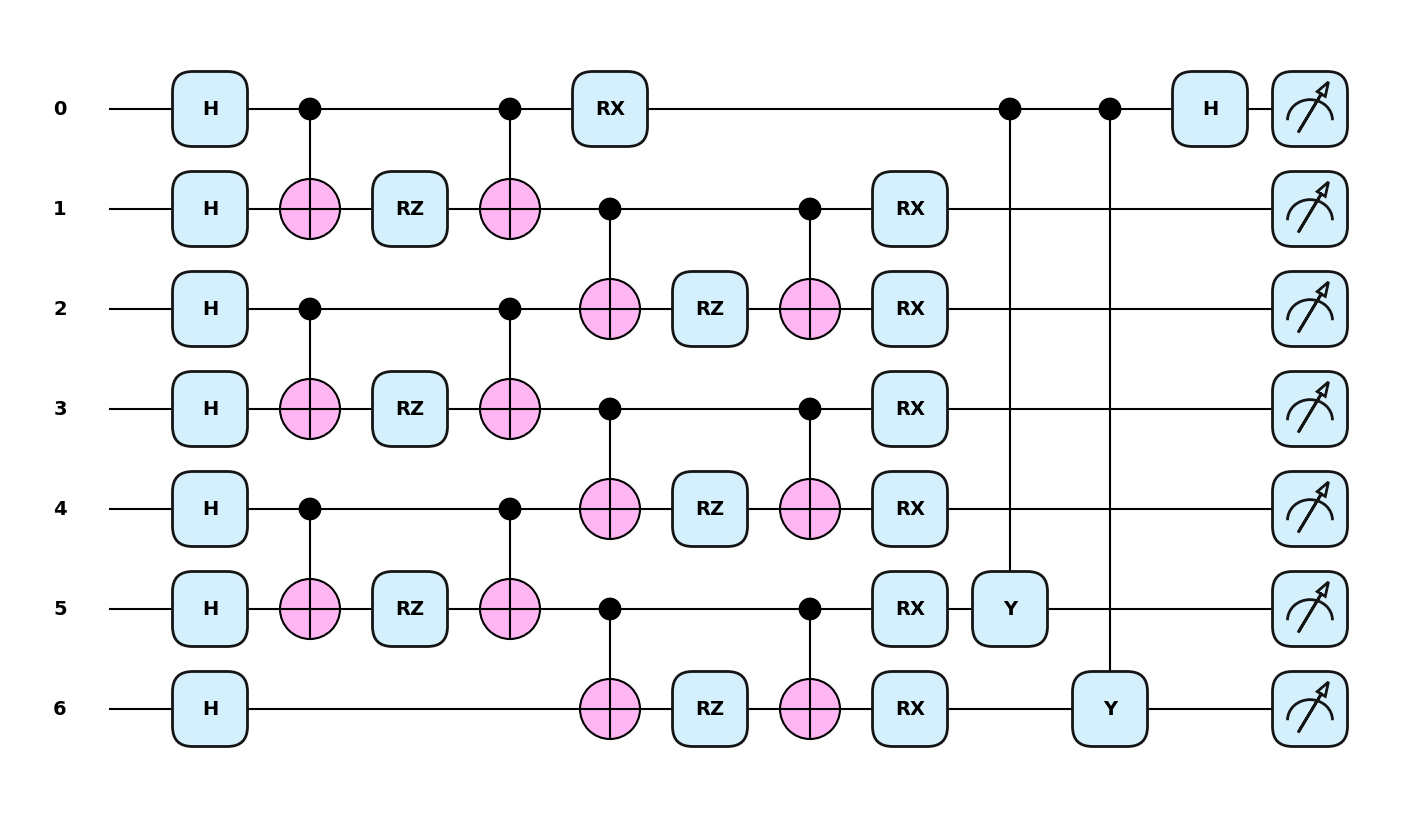

In [20]:
qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(vqnhe)(initial_weights, 'XIIIIYY')
plt.show()

Function that calculates the energy of the TFIM via VQNHE

In [21]:
def vqnhe_nrg(NN, weights, j=1, h=-1):
    
    # Dynamic Hamiltonian generation
    zz_hamiltonian = 'Z' * nq
    x_hamiltonians = ['I' * i + 'X' + 'I' * (nq - i - 1) for i in range(nq)]
    
    ###########PQC Measure###########
    probs = {zz_hamiltonian: vqnhe(weights, zz_hamiltonian)}
    for ham in x_hamiltonians:
        probs[ham] = vqnhe(weights, ham)
    
    
    norm = torch.tensor(0.0)
    interaction = torch.tensor(0.0)
    field = torch.tensor(0.0)
    
    ###########Calculate Norm & Interaction Energy###########
    for i in range(2**nq):
        state = format(i, f'0{nq}b')
        spin = [int(bit) for bit in state]
        input_s = torch.tensor(spin, dtype=torch.float32)
        fs = NN(input_s)
        
        norm = norm + fs * fs * probs[zz_hamiltonian][i]
        
        for k in range(nq-1):
            if state[k] == state[k+1]:
                interaction = interaction + fs * fs * probs[zz_hamiltonian][i]
            else:
                interaction = interaction - fs * fs * probs[zz_hamiltonian][i]
                
    interaction = interaction/norm
    
    ############Calculate Field Energy###########

    
    for configuration in x_hamiltonians:
        XYs = []
        Zs = []
            
        for i, char in enumerate(configuration):
            
            if char in ['X', 'Y']:
                XYs.append(i) 
                
            if char == ['Z']:
                Zs.append(i)
                

        for i in range(2**nq):
            
            state = format(i, f'0{nq}b')
            spin = [int(bit) for bit in state]
            spin_star = spin.copy()
            
            spin_star[XYs[0]] = 0
            spin_tilda = spin_star.copy()
                
            for idx in XYs:
                spin_tilda[idx] = 1 - spin_tilda[idx]
                
                
            input_s = torch.tensor(spin, dtype=torch.float32)    
            input_s_star = torch.tensor(spin_star, dtype=torch.float32)
            input_s_tilda = torch.tensor(spin_tilda, dtype=torch.float32)
            
            fs = NN(input_s)  #when star qubit get to be 0
            fs_star = NN(input_s_star)
            fs_tilda = NN(input_s_tilda) #when start qubit get to be 1
            
            
            product_term = (1 - 2*spin[XYs[0]])
            
            for idx in Zs:
                product_term = product_term * (1 - 2*spin[idx])
                    
            field = field + (product_term * fs_star * fs_tilda) * probs[configuration][i] 
            
    field = field / norm
    
    E = j * interaction + h * field
    E.requires_grad_(True)
    return E

In [22]:
vqe_weights = torch.tensor(trained_vqe_weights, dtype=torch.float32, requires_grad=True)
fnn_opt = optim.Adam(NN.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(fnn_opt, 'min', patience=10, factor=0.1, verbose=True)

/Users/jiseoksong/anaconda3/envs/vqnhe/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [23]:
vqnhe_energies = []
NN_weights = []
optimization_step = 500

Train the PQC of VQE 

We set the parameters of the PQC of VQNHE obtained from VQE-PQC.

You can think the classical neural network post processes the VQE-PQC for higher accuracy.

In [24]:
for step in range(optimization_step):  

    fnn_opt.zero_grad()
    
    energy = vqnhe_nrg(NN, vqe_weights, j, h)
    energy.backward()

    fnn_opt.step()
    vqnhe_energies.append(energy.item())
    NN_weights.append(NN.parameters())
    
    scheduler.step(energy.item())
    
    if (step+1) % 10 == 0:
        print(f"Phase 2 - Step {step+1}, Joint Energy: {energy.item()}")

Phase 2 - Step 10, Joint Energy: -7.999224662780762
Phase 2 - Step 20, Joint Energy: -8.01364517211914
Phase 2 - Step 30, Joint Energy: -8.005899429321289
Phase 2 - Step 40, Joint Energy: -8.056140899658203
Phase 2 - Step 50, Joint Energy: -8.261337280273438
Phase 2 - Step 60, Joint Energy: -8.237478256225586
Phase 2 - Step 70, Joint Energy: -8.326864242553711
Phase 2 - Step 80, Joint Energy: -8.340187072753906
Phase 2 - Step 90, Joint Energy: -8.314449310302734
Phase 2 - Step 100, Joint Energy: -8.334369659423828
Phase 2 - Step 110, Joint Energy: -8.347970008850098
Phase 2 - Step 120, Joint Energy: -8.32853889465332
Phase 2 - Step 130, Joint Energy: -8.331043243408203
Phase 2 - Step 140, Joint Energy: -8.324960708618164
Phase 2 - Step 150, Joint Energy: -8.34565258026123
Phase 2 - Step 160, Joint Energy: -8.338687896728516
Phase 2 - Step 170, Joint Energy: -8.343034744262695
Phase 2 - Step 180, Joint Energy: -8.345197677612305
Phase 2 - Step 190, Joint Energy: -8.341124534606934
Phase

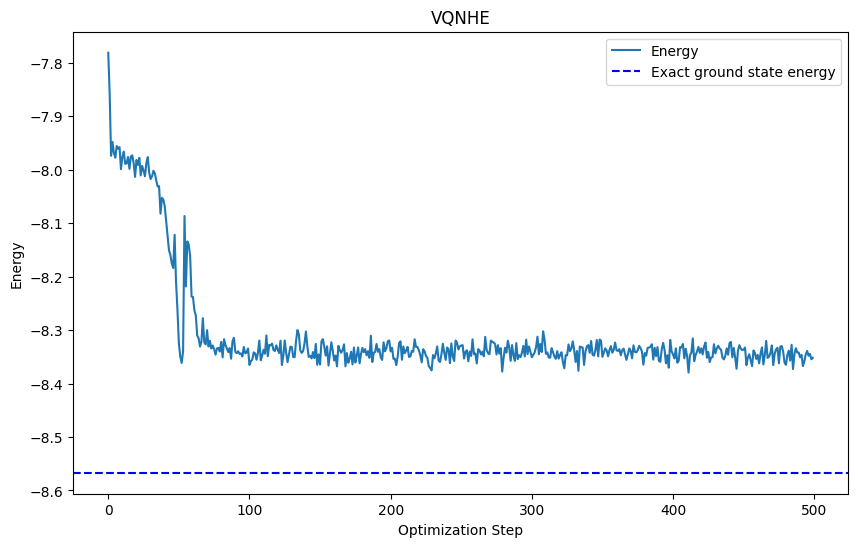

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(vqnhe_energies, label='Energy')
# plt.axvline(x=phase_shift, color='r', linestyle='--', label='Neural network starts to learn')
plt.axhline(y=exact_solution, color='b', linestyle='--', label='Exact ground state energy')
plt.xlabel('Optimization Step')
plt.ylabel('Energy')
plt.title('VQNHE')
plt.legend()


plt.savefig(f'tfim_vqnhe_{nq}_site_{n_layers}_layers.png', dpi=300) 
plt.show()

Result of the VQNHE

In [26]:
print(min(vqnhe_energies))
min_index = vqnhe_energies.index(min(vqnhe_energies))
trained_NN_weights = NN_weights[min_index]

-8.379535675048828


In [27]:
trained_vqnhe_energies = []
for i in range(100):
    trained_vqnhe_energies.append(vqnhe_nrg(NN, vqe_weights, j, h).detach().item())

In [28]:
print(trained_vqe_energies)
print(trained_vqnhe_energies)


[array(-8.27766667), array(-8.27626667), array(-8.30026667), array(-8.28126667), array(-8.2846), array(-8.31886667), array(-8.2866), array(-8.26173333), array(-8.28806667), array(-8.2956), array(-8.28173333), array(-8.24466667), array(-8.27853333), array(-8.29093333), array(-8.26826667), array(-8.28326667), array(-8.27893333), array(-8.30073333), array(-8.29913333), array(-8.27426667), array(-8.281), array(-8.25573333), array(-8.26446667), array(-8.31313333), array(-8.2986), array(-8.2638), array(-8.31406667), array(-8.29226667), array(-8.30226667), array(-8.2962), array(-8.28966667), array(-8.2522), array(-8.27133333), array(-8.28746667), array(-8.25553333), array(-8.281), array(-8.2622), array(-8.28546667), array(-8.293), array(-8.287), array(-8.29773333), array(-8.28933333), array(-8.29386667), array(-8.30613333), array(-8.28746667), array(-8.2706), array(-8.26973333), array(-8.27433333), array(-8.30186667), array(-8.27253333), array(-8.2924), array(-8.2958), array(-8.30586667), arr

In [29]:
vqe_mean = np.mean(trained_vqe_energies)
vqnhe_mean = np.mean(trained_vqnhe_energies)
vqe_std = np.std(trained_vqe_energies)
vqnhe_std = np.std(trained_vqnhe_energies)

In [30]:
print(vqe_mean)
print(vqnhe_mean)

-8.28484333333332
-8.341635875701904


Comparison between VQE and VQNHE

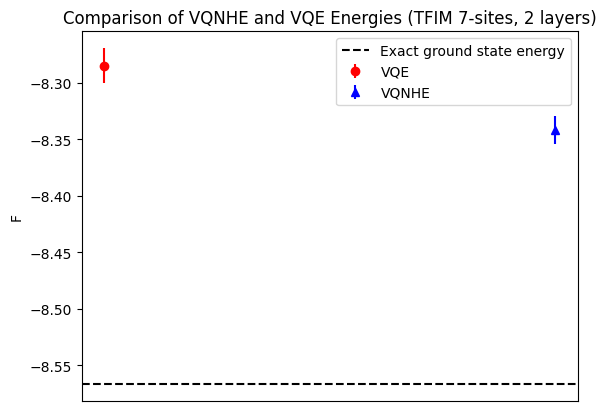

In [31]:

ind = np.arange(1)

width = 0.1

fig, ax = plt.subplots()

ax.errorbar(ind - width, vqe_mean, yerr=vqe_std, fmt='o', color='red', label='VQE')
ax.errorbar(ind + width, vqnhe_mean, yerr=vqnhe_std, fmt='^', color='blue', label='VQNHE')

ax.set_ylabel('F')
ax.set_title(f'Comparison of VQNHE and VQE Energies (TFIM {nq}-sites, {n_layers} layers)')
ax.set_xticks([])
plt.axhline(y=exact_solution, color='black', linestyle='--', label='Exact ground state energy')


ax.legend()

plt.show()